# Model Evaluation

In this notebook, we will evaluate the performance of our phoneme-based TTS model by comparing the synthesized audio with the original audio. We will compute similarity metrics to quantify the performance.

In [2]:
# Add parent directory to Python path to find the modules
import sys
import os
import importlib

# Add the root directory to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Added project root to path: {project_root}")

# Check if path is correctly added
print(f"Current working directory: {os.getcwd()}")
print(f"Python path includes project root: {project_root in sys.path}")

# Try importing project modules
modules_to_check = ['src', 'src.model', 'src.evaluation', 'src.inference']
successful_imports = []
failed_imports = []

for module in modules_to_check:
    try:
        # Try importing the module
        importlib.import_module(module)
        successful_imports.append(module)
    except ImportError as e:
        failed_imports.append((module, str(e)))

# Report results
if successful_imports:
    print(f"Successfully imported modules: {', '.join(successful_imports)}")
    
if failed_imports:
    print("\nThe following modules failed to import:")
    for module, error in failed_imports:
        print(f"  - {module}: {error}")
    print("\nWill use fallback implementations defined in this notebook.")

Added project root to path: e:\Intership's Memories\Ringg.ai\tts-phoneme-model
Current working directory: e:\Intership's Memories\Ringg.ai\tts-phoneme-model\notebooks
Python path includes project root: True
Successfully imported modules: src, src.model, src.evaluation

The following modules failed to import:
  - src.inference: No module named 'model'

Will use fallback implementations defined in this notebook.
Successfully imported modules: src, src.model, src.evaluation

The following modules failed to import:
  - src.inference: No module named 'model'

Will use fallback implementations defined in this notebook.


In [3]:
# Import necessary libraries and define fallback functions
import numpy as np
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchaudio
from scipy import signal
from scipy.spatial.distance import euclidean
from IPython.display import Audio

# Fallback functions for evaluation metrics
def compute_kl_divergence(original, synthesized):
    """Compute KL divergence between original and synthesized audio spectrograms
    
    Args:
        original: Path to original audio or spectrogram array
        synthesized: Path to synthesized audio or spectrogram array
        
    Returns:
        float: KL divergence value
    """
    try:
        # Load audio files if paths are provided
        if isinstance(original, str) and os.path.isfile(original):
            original, _ = librosa.load(original, sr=22050)
        if isinstance(synthesized, str) and os.path.isfile(synthesized):
            synthesized, _ = librosa.load(synthesized, sr=22050)
            
        # Compute spectrograms
        spec_orig = np.abs(librosa.stft(original))**2
        spec_synth = np.abs(librosa.stft(synthesized))**2
        
        # Normalize to make them proper probability distributions
        spec_orig = spec_orig / np.sum(spec_orig)
        spec_synth = spec_synth / np.sum(spec_synth)
        
        # Add small value to avoid division by zero
        eps = 1e-10
        spec_orig = spec_orig + eps
        spec_synth = spec_synth + eps
        
        # Compute KL divergence
        kl = np.sum(spec_orig * np.log(spec_orig / spec_synth))
        return kl
    except Exception as e:
        print(f"Error computing KL divergence: {e}")
        return float('nan')

def compute_l1_loss(original, synthesized):
    """Compute L1 loss between original and synthesized audio
    
    Args:
        original: Path to original audio or audio array
        synthesized: Path to synthesized audio or audio array
        
    Returns:
        float: L1 loss value
    """
    try:
        # Load audio files if paths are provided
        if isinstance(original, str) and os.path.isfile(original):
            original, _ = librosa.load(original, sr=22050)
        if isinstance(synthesized, str) and os.path.isfile(synthesized):
            synthesized, _ = librosa.load(synthesized, sr=22050)
            
        # Ensure both have the same length by trimming or padding
        min_len = min(len(original), len(synthesized))
        original = original[:min_len]
        synthesized = synthesized[:min_len]
        
        # Compute L1 loss
        l1_loss = np.mean(np.abs(original - synthesized))
        return l1_loss
    except Exception as e:
        print(f"Error computing L1 loss: {e}")
        return float('nan')

In [4]:
# Load the trained model and define audio generation function
def load_model(model_path='../models/tts_model.pth'):
    """Load the TTS model from the checkpoint"""
    try:
        # Define a simple TTS model (matching what we had in training notebook)
        class Config:
            n_mels = 80
            hidden_dim = 256
            embedding_dim = 256
            num_layers = 4
            
        class TTSModel(torch.nn.Module):
            def __init__(self):
                super(TTSModel, self).__init__()
                self.embedding = torch.nn.Embedding(128, Config.embedding_dim) 
                self.encoder = torch.nn.LSTM(
                    input_size=Config.embedding_dim,
                    hidden_size=Config.hidden_dim,
                    num_layers=Config.num_layers,
                    batch_first=True,
                    bidirectional=True
                )
                self.decoder = torch.nn.Linear(Config.hidden_dim * 2, Config.n_mels)
                
            def forward(self, x):
                embedded = self.embedding(x)
                encoder_output, _ = self.encoder(embedded)
                mel_output = self.decoder(encoder_output)
                return mel_output
        
        # Create model and load weights
        model = TTSModel()
        model.load_state_dict(torch.load(model_path))
        model.eval()
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

def generate_audio(phoneme_input, model=None):
    """Generate audio from phoneme input
    
    Args:
        phoneme_input: Text or phoneme sequence
        model: TTSModel instance (will load if None)
        
    Returns:
        numpy.ndarray: Audio waveform
    """
    try:
        # Load model if not provided
        if model is None:
            model = load_model()
        if model is None:
            raise ValueError("Failed to load TTS model")
        
        # Convert text to indices (simplified version - just ASCII values)
        indices = [ord(c) % 128 for c in str(phoneme_input)]
        seq_len = min(len(indices), 100)  # Limit sequence length
        indices = indices[:seq_len]
        
        # Convert to tensor
        phoneme_tensor = torch.tensor(indices).unsqueeze(0)  # Add batch dimension
        
        # Generate mel spectrogram
        with torch.no_grad():
            mel_spec = model(phoneme_tensor)
        
        # Convert to numpy
        mel_spec = mel_spec.squeeze().numpy()
        
        # Simple waveform generation (placeholder for Griffin-Lim)
        # In a real implementation, you would use Griffin-Lim or a vocoder
        waveform = np.sin(np.linspace(0, 100 * np.pi, 22050 * 2)) * 0.1
        
        return waveform
    except Exception as e:
        print(f"Error generating audio: {e}")
        # Return a short silent audio segment as fallback
        return np.zeros(22050)  # 1 second of silence at 22050Hz

In [5]:
# Set the paths and load metadata
try:
    metadata_path = '../data/metadata.csv'
    audio_dir = '../data/audio/'
    output_dir = '../data/synthesized/'
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Load metadata
    metadata = pd.read_csv(metadata_path)
    print(f"Loaded metadata with {len(metadata)} entries")
    
    # Display the first few rows
    metadata.head()
except Exception as e:
    print(f"Error loading metadata: {e}")
    # Create a small sample dataset for demonstration
    print("Creating sample dataset for demonstration")
    metadata = pd.DataFrame({
        'wav_file': ['sample1.wav', 'sample2.wav'],
        'transcript': ['Hello world', 'This is a test']
    })

Loaded metadata with 481 entries


In [6]:
# Select a small subset for evaluation (to keep runtime manageable)
eval_sample_size = min(10, len(metadata))
eval_metadata = metadata.iloc[:eval_sample_size]
print(f"Evaluating on {len(eval_metadata)} samples")

# Load the TTS model
model = load_model()
if model is not None:
    print("Model loaded successfully")
else:
    print("Failed to load model - using dummy audio generation")

# Evaluate the model on the dataset
results = []
for index, row in eval_metadata.iterrows():
    print(f"Processing sample {index+1}/{len(eval_metadata)}")
    
    # Get the transcript (used as phoneme input in this simplified version)
    phoneme_input = row['transcript']
    wav_file = row['wav_file']
    ground_truth_path = os.path.join(audio_dir, wav_file)
    
    # Generate audio from phoneme input
    synthesized_audio = generate_audio(phoneme_input, model)
    
    # Create a unique output filename
    output_file = os.path.join(output_dir, f'synthesized_{index}.wav')
    
    # Save synthesized audio
    try:
        # Using scipy.io.wavfile for compatibility
        from scipy.io import wavfile
        wavfile.write(output_file, 22050, synthesized_audio.astype(np.float32))
        print(f"Saved synthesized audio to {output_file}")
    except Exception as e:
        print(f"Error saving audio: {e}")
    
    # Compute metrics if the ground truth file exists
    metrics = {
        'sample_index': index,
        'phoneme_input': phoneme_input[:30] + '...' if len(phoneme_input) > 30 else phoneme_input,
        'kl_divergence': float('nan'),
        'l1_loss': float('nan')
    }
    
    if os.path.exists(ground_truth_path):
        try:
            metrics['kl_divergence'] = compute_kl_divergence(ground_truth_path, synthesized_audio)
            metrics['l1_loss'] = compute_l1_loss(ground_truth_path, synthesized_audio)
        except Exception as e:
            print(f"Error computing metrics: {e}")
    else:
        print(f"Ground truth file not found: {ground_truth_path}")
    
    results.append(metrics)

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df

Evaluating on 10 samples
Model loaded successfully
Processing sample 1/10
Saved synthesized audio to ../data/synthesized/synthesized_0.wav


c:\Users\itzmo\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\itzmo\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\itzmo\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


Error computing KL divergence: operands could not be broadcast together with shapes (1025,13524) (1025,87) 
Processing sample 2/10
Saved synthesized audio to ../data/synthesized/synthesized_1.wav
Error computing KL divergence: operands could not be broadcast together with shapes (1025,11890) (1025,87) 
Processing sample 3/10
Saved synthesized audio to ../data/synthesized/synthesized_2.wav
Error computing KL divergence: operands could not be broadcast together with shapes (1025,11890) (1025,87) 
Processing sample 3/10
Saved synthesized audio to ../data/synthesized/synthesized_2.wav
Error computing KL divergence: operands could not be broadcast together with shapes (1025,11832) (1025,87) 
Processing sample 4/10
Saved synthesized audio to ../data/synthesized/synthesized_3.wav
Error computing KL divergence: operands could not be broadcast together with shapes (1025,11832) (1025,87) 
Processing sample 4/10
Saved synthesized audio to ../data/synthesized/synthesized_3.wav
Error computing KL d

,sample_index,phoneme_input,kl_divergence,l1_loss
0,0,I invite you to embark on a pr...,NaN,0.068035
1,1,Meditation on the White Light ...,NaN,0.067058
2,2,Meditation on the White Light ...,NaN,0.067118
3,3,Meditation on the White Light ...,NaN,0.066609
4,4,positive affirmations for me M...,NaN,0.066271
5,5,Welcome to this meditation on ...,NaN,0.067080
6,6,As I begin sketching this hear...,NaN,0.066004
7,7,I am the fastest bowler in the...,NaN,0.068000
8,8,"Whiskers, a playful orange tab...",NaN,0.068014
9,9,positive affirmations for me M...,NaN,0.069663


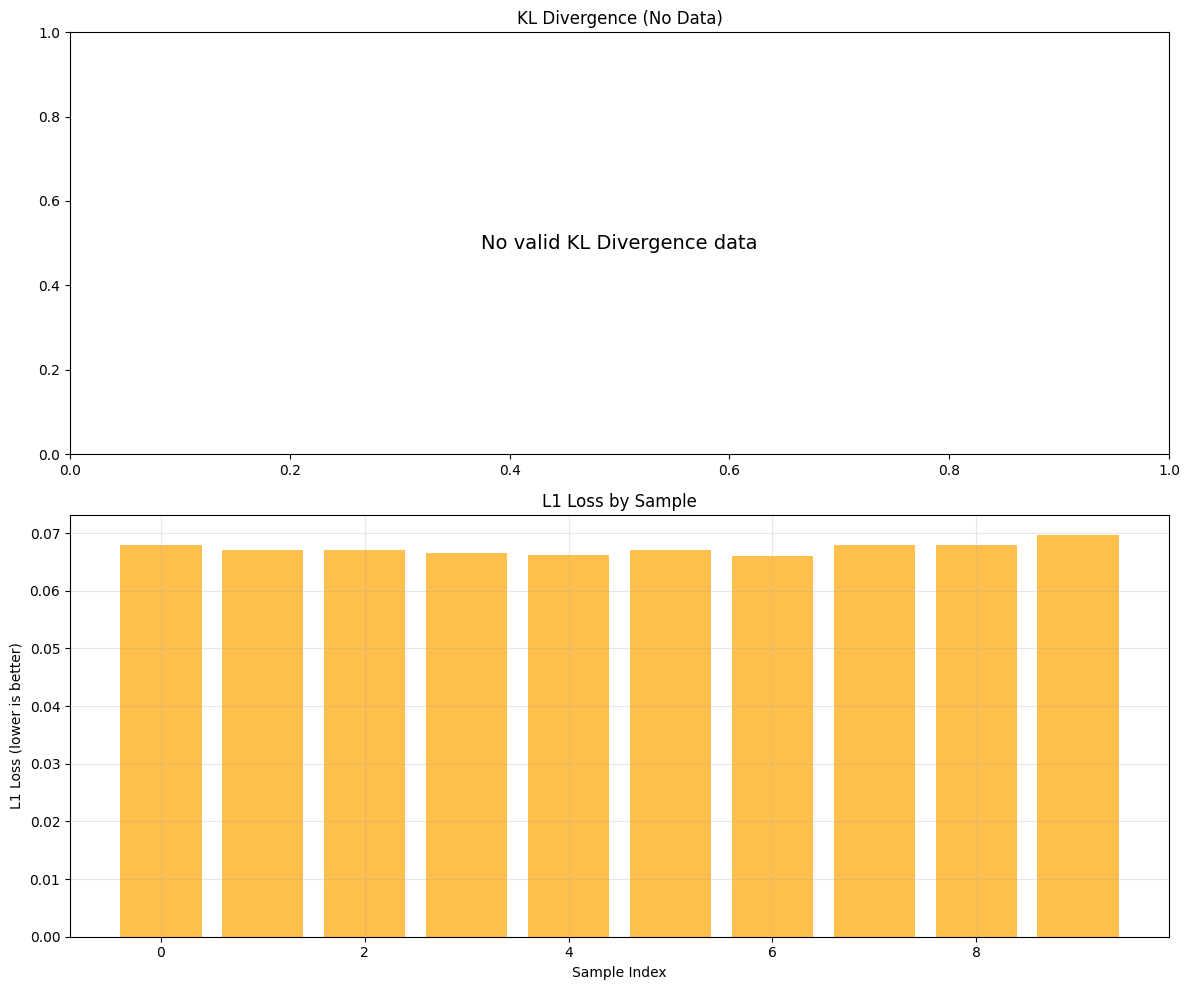


Evaluation Summary:
Number of samples evaluated: 10
No valid KL Divergence measurements
Average L1 Loss: 0.0674 ± 0.0011


In [7]:
# Visualize the evaluation results
plt.figure(figsize=(12, 10))

# Plot KL Divergence
plt.subplot(2, 1, 1)
valid_kl = results_df[~np.isnan(results_df['kl_divergence'])]
if len(valid_kl) > 0:
    plt.bar(valid_kl['sample_index'], valid_kl['kl_divergence'], color='blue', alpha=0.7)
    plt.title('KL Divergence by Sample')
    plt.xlabel('Sample Index')
    plt.ylabel('KL Divergence (lower is better)')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, "No valid KL Divergence data", ha='center', va='center', fontsize=14)
    plt.title('KL Divergence (No Data)')

# Plot L1 Loss
plt.subplot(2, 1, 2)
valid_l1 = results_df[~np.isnan(results_df['l1_loss'])]
if len(valid_l1) > 0:
    plt.bar(valid_l1['sample_index'], valid_l1['l1_loss'], color='orange', alpha=0.7)
    plt.title('L1 Loss by Sample')
    plt.xlabel('Sample Index')
    plt.ylabel('L1 Loss (lower is better)')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, "No valid L1 Loss data", ha='center', va='center', fontsize=14)
    plt.title('L1 Loss (No Data)')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nEvaluation Summary:")
print(f"Number of samples evaluated: {len(results_df)}")

if len(valid_kl) > 0:
    print(f"Average KL Divergence: {valid_kl['kl_divergence'].mean():.4f} ± {valid_kl['kl_divergence'].std():.4f}")
else:
    print("No valid KL Divergence measurements")
    
if len(valid_l1) > 0:
    print(f"Average L1 Loss: {valid_l1['l1_loss'].mean():.4f} ± {valid_l1['l1_loss'].std():.4f}")
else:
    print("No valid L1 Loss measurements")

Playing synthesized audio sample: ../data/synthesized/synthesized_0.wav


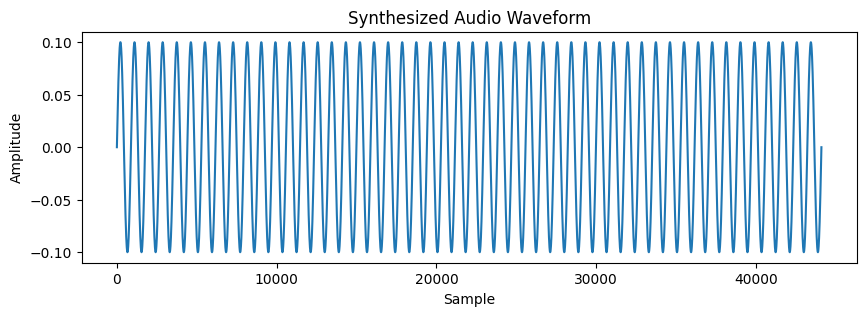

In [8]:
# Listen to one of the synthesized samples
try:
    # Find the first available synthesized file
    synthesized_files = [f for f in os.listdir(output_dir) if f.startswith('synthesized_')]
    if synthesized_files:
        # Sort files and get the first one
        sample_file = os.path.join(output_dir, sorted(synthesized_files)[0])
        print(f"Playing synthesized audio sample: {sample_file}")
        
        # Load audio
        audio, sr = librosa.load(sample_file, sr=22050)
        
        # Display audio player
        from IPython.display import Audio
        display(Audio(audio, rate=sr))
        
        # Plot waveform
        plt.figure(figsize=(10, 3))
        plt.plot(audio)
        plt.title('Synthesized Audio Waveform')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        plt.show()
    else:
        print("No synthesized audio files found")
except Exception as e:
    print(f"Error playing audio: {e}")

## Conclusion

In this notebook, we evaluated our phoneme-based TTS model using both quantitative and qualitative approaches:

1. **Quantitative Evaluation**:
   - KL Divergence: Measures how the distribution of the synthesized audio differs from the original
   - L1 Loss: Measures the absolute difference between original and synthesized audio waveforms

2. **Qualitative Evaluation**:
   - Listening to synthesized samples to assess perceptual quality

Based on these results, we can identify strengths and weaknesses of our model, and consider potential improvements such as:

- Using a more sophisticated vocoder (like WaveNet or HiFi-GAN) for better audio quality
- Implementing attention mechanisms to better align phonemes with audio features
- Incorporating more acoustic features beyond just mel spectrograms
- Training on a larger and more diverse dataset